# Context
This notebook drives the training process for different models.

In [396]:
# Set project's environment variables
import os
import sys
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../../project.env")
sys.path.append(os.environ["PYTHONPATH"])

In [397]:
# Import project-wide and PH2 specific variables and functions
import superheader as sup

In [398]:
def get_latest_file(folder_path):
  files = [f for f in os.listdir(folder_path) if "_" in f]
  latest = max(files)
  return os.path.join(folder_path, latest)

TRAIN_classes = "ten-classes"
num_classes = 10
scores_path = get_latest_file(
  os.path.join(sup.SCORES_ROOT, 
               "specified", 
               sup.TRAIN_BERT_CODE, 
               TRAIN_classes))

print(scores_path)

top_barrier=5

/Users/diego/Desktop/iteso/TOG/scores/specified/BERT/ten-classes/PREPanalysis-2025-06-15_17:15:22.csv


## Helper functions

In [399]:
import math

def significance(row, score_col):
  C = int(row["num_classes"])
  score = row[score_col]

  k = 2 if score_col == 'top2accuracy' else 1
  if C == k:
    return 0
  
  # Chance the true class appears in a random top-k set:
  # Choose (k - 1) other classes from the remaining (C - 1), then divide by all
  # possible top-k sets
  # chance_score = math.comb(C - 1, k - 1)  /  math.comb(C, k)
  #       "      = ((C-1)! / ((C-1-(k-1))! * (k-1)!))  /  (C! / ((C-k)! * k!))
  #       "      = ((C-1)! / ((C-k)! * (k-1)!))  /  (C! / ((C-k)! * k!))
  #       "      = ((C-1)! / (k-1)!)  /  (C! / k!)
  #       "      = ((C-1)! / C!)  /  ((k-1)! / k!)
  #       "      = (k! / (k-1)!) / (C! / (C-1)!)
  #       "      = k / C
  # So:
  chance_score = k / C

  if score_col == 'accuracy' or score_col == 'top2accuracy':
    std = math.sqrt(chance_score * (1 - chance_score) / 100 * C)
  elif score_col == 'macro_recall':
    std = math.sqrt((1 - chance_score) / (100 * C**2))
  elif score_col == 'macro_precision':
    std = math.sqrt((C - 1) / (100 * C**2))

  z = (score - chance_score)/std

  return z

def harmonic_z(row, recall_col='macro_recall_z', precision_col='macro_precision_z'):
    recall_z = row[recall_col]
    precision_z = row[precision_col]

    # Handle zero or undefined cases
    if recall_z + precision_z == 0:
        return 0  # or np.nan if you want to mark it

    return 2 * recall_z * precision_z / (recall_z + precision_z)
                

In [400]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [401]:
def visualize(df: pd.DataFrame, group_cols, top, filter_cols=None, filter_values=None, sortby='accuracy_z'):
  """
  Optionally filters df by filter_cols == filter_values, groups by group_cols,
  selects top `top` rows by accuracy, computes mean accuracy, and plots the result.
  """
  filter_desc = ""

  # Optional filtering
  if filter_cols and filter_values:
    for col, val in zip(filter_cols, filter_values):
      df = df[df[col] == val]
    filter_desc = " | " + " & ".join(f"{col}={val}" for col, val in zip(filter_cols, filter_values))

  if df.empty:
    print("Warning: DataFrame is empty after filtering.")
    return

  # Group + mean of top k
  def top_k_mean(g):
    top_k = g.sort_values(f'{sortby}', ascending=False).head(top)
    if top_k.empty:
      return float('nan')  # or 0.0
    return top_k[f'{sortby}'].mean()

  mean_accuracies = (
      df.groupby(group_cols)
        .apply(top_k_mean)
        .to_frame(f'mean_{sortby}')
        .reset_index()
  )

  if mean_accuracies.empty:
    print("Warning: No data to plot after grouping.")
    return

  # Create labels
  mean_accuracies['label'] = mean_accuracies[group_cols].astype(str).agg(' | '.join, axis=1)

  # Plotting
  colors = sns.color_palette("muted", len(mean_accuracies))
  plt.figure(figsize=(20, 12))
  plt.bar(mean_accuracies['label'], mean_accuracies[f'mean_{sortby}'], color=colors)

  plt.ylabel(f"Mean Accuracy (Top {top})")
  plt.title(f"Top {top} Mean {sortby} per {' + '.join(group_cols)}{filter_desc}")
  plt.xticks(rotation=45, ha='right')

  # Add y-limit padding
  min_val = mean_accuracies[f'mean_{sortby}'].min()
  max_val = mean_accuracies[f'mean_{sortby}'].max()
  padding = (max_val - min_val) * 0.3 if max_val > min_val else 0.1
  #plt.ylim(max(min_val - padding, 0), min(max_val + padding, 1))

  # Add value labels
  for i, val in enumerate(mean_accuracies[f'mean_{sortby}']):
    plt.text(i, val + padding * 0.002, f"{val:.3f}", ha='center', va='bottom', fontsize=9)

  plt.tight_layout()
  plt.show()



In [402]:
def evolution(df, metric='accuracy_z', prep_cols=None):
  if prep_cols is None:
    prep_cols = []

  df = df.copy()

  # Use raw values to construct readable prep label
  def describe_prep(row):
    parts = [f"{col}={row[col]}" for col in prep_cols]
    return ' | '.join(parts)

  df['prep_label'] = df.apply(describe_prep, axis=1)

  prep_label_text = ', '.join(prep_cols) if prep_cols else 'no prep columns'

  # Plot
  plt.figure(figsize=(12, 6))
  sns.lineplot(data=df, x='num_classes', y=metric, hue='prep_label', marker='o')
  plt.title(f'{metric} vs. Number of Classes by: {prep_label_text}')
  plt.xlabel('Number of Classes')
  plt.ylabel(metric)
  plt.grid(True)
  plt.tight_layout()
  plt.legend(title=f'Prep Strategy ({prep_label_text})', bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.show()


## Data

In [403]:
scores_df = pd.read_csv(scores_path)
scores_df.sort_values(by="accuracy", ascending=False)

,data_unit,class_list,difficulty,num_classes,class_name_list,PH2,PH3,reducer,kernel,num_components,batch_size,num_epochs,loadable,accuracy,top2accuracy,macro_f1,macro_precision,macro_recall
575,Spv,specified,hard,2,"['c', 'f']",False,False,NaN,NaN,72,1024,0,gaunernst/bert-tiny-uncased,0.666667,1.000000,0.646635,0.715543,0.666667
6,Spf,specified,easy,2,"['a', 'c']",True,True,pca,NaN,7,1024,0,gaunernst/bert-tiny-uncased,0.655039,1.000000,0.628465,0.728534,0.659344
505,Spv,specified,easy,2,"['a', 'c']",False,True,pca,NaN,10,1024,0,gaunernst/bert-tiny-uncased,0.651163,1.000000,0.621701,0.738562,0.658009
550,Spv,specified,hard,2,"['c', 'f']",True,True,pca,NaN,7,1024,0,gaunernst/bert-tiny-uncased,0.642857,1.000000,0.590643,0.791667,0.642857
64,Spf,specified,hard,2,"['c', 'f']",True,True,pca,NaN,1,1024,0,gaunernst/bert-tiny-uncased,0.596000,1.000000,0.595974,0.596042,0.596078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,Spf,specified,average,8,"['c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']",True,True,pca,NaN,7,1024,0,gaunernst/bert-tiny-uncased,0.084320,0.210552,0.037151,0.024345,0.088091
323,Spf,specified,average,8,"['c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']",True,True,pca,NaN,4,1024,0,gaunernst/bert-tiny-uncased,0.075444,0.312623,0.040643,0.165040,0.075537
324,Spf,specified,average,8,"['c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']",True,True,pca,NaN,5,1024,0,gaunernst/bert-tiny-uncased,0.071006,0.250986,0.029128,0.025257,0.069220
860,Spv,specified,hard,8,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'i']",False,True,pca,NaN,13,1024,0,gaunernst/bert-tiny-uncased,0.070588,0.258824,0.025071,0.016098,0.068723


In [404]:
print(scores_df.columns.to_list())

['data_unit', 'class_list', 'difficulty', 'num_classes', 'class_name_list', 'PH2', 'PH3', 'reducer', 'kernel', 'num_components', 'batch_size', 'num_epochs', 'loadable', 'accuracy', 'top2accuracy', 'macro_f1', 'macro_precision', 'macro_recall']


In [405]:
for metric_name in ['accuracy', 'top2accuracy', 'macro_precision', 'macro_recall']:
  scores_df[f'{metric_name}_z'] = scores_df.apply(lambda x: significance(x, metric_name), axis=1)

scores_df['harmonic_z'] = scores_df.apply(harmonic_z, axis=1)

scores_df

,data_unit,class_list,difficulty,num_classes,class_name_list,PH2,PH3,reducer,kernel,num_components,...,accuracy,top2accuracy,macro_f1,macro_precision,macro_recall,accuracy_z,top2accuracy_z,macro_precision_z,macro_recall_z,harmonic_z
0,Spf,specified,easy,2,"['a', 'c']",True,True,pca,NaN,1,...,0.507752,1.000000,0.336761,0.253876,0.500000,0.109629,0.000000,-4.922481,0.000000,0.000000
1,Spf,specified,easy,2,"['a', 'c']",True,True,pca,NaN,2,...,0.507752,1.000000,0.336761,0.253876,0.500000,0.109629,0.000000,-4.922481,0.000000,0.000000
2,Spf,specified,easy,2,"['a', 'c']",True,True,pca,NaN,3,...,0.492248,1.000000,0.329870,0.246124,0.500000,-0.109629,0.000000,-5.077519,0.000000,0.000000
3,Spf,specified,easy,2,"['a', 'c']",True,True,pca,NaN,4,...,0.492248,1.000000,0.329870,0.246124,0.500000,-0.109629,0.000000,-5.077519,0.000000,0.000000
4,Spf,specified,easy,2,"['a', 'c']",True,True,pca,NaN,5,...,0.492248,1.000000,0.329870,0.246124,0.500000,-0.109629,0.000000,-5.077519,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,Spv,specified,hard,10,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",False,True,pca,NaN,12,...,0.400943,0.669811,0.346304,0.445701,0.401255,3.172222,3.714185,11.523371,31.755109,16.910294
956,Spv,specified,hard,10,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",False,True,pca,NaN,13,...,0.443396,0.669811,0.423258,0.490262,0.440693,3.619714,3.714185,13.008740,35.912158,19.099073
957,Spv,specified,hard,10,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",False,True,pca,NaN,14,...,0.391509,0.608491,0.357012,0.409552,0.389675,3.072779,3.229401,10.318392,30.534460,15.424457
958,Spv,specified,hard,10,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",False,True,pca,NaN,15,...,0.372642,0.650943,0.332005,0.376678,0.371970,2.873894,3.565021,9.222593,28.668123,13.955631


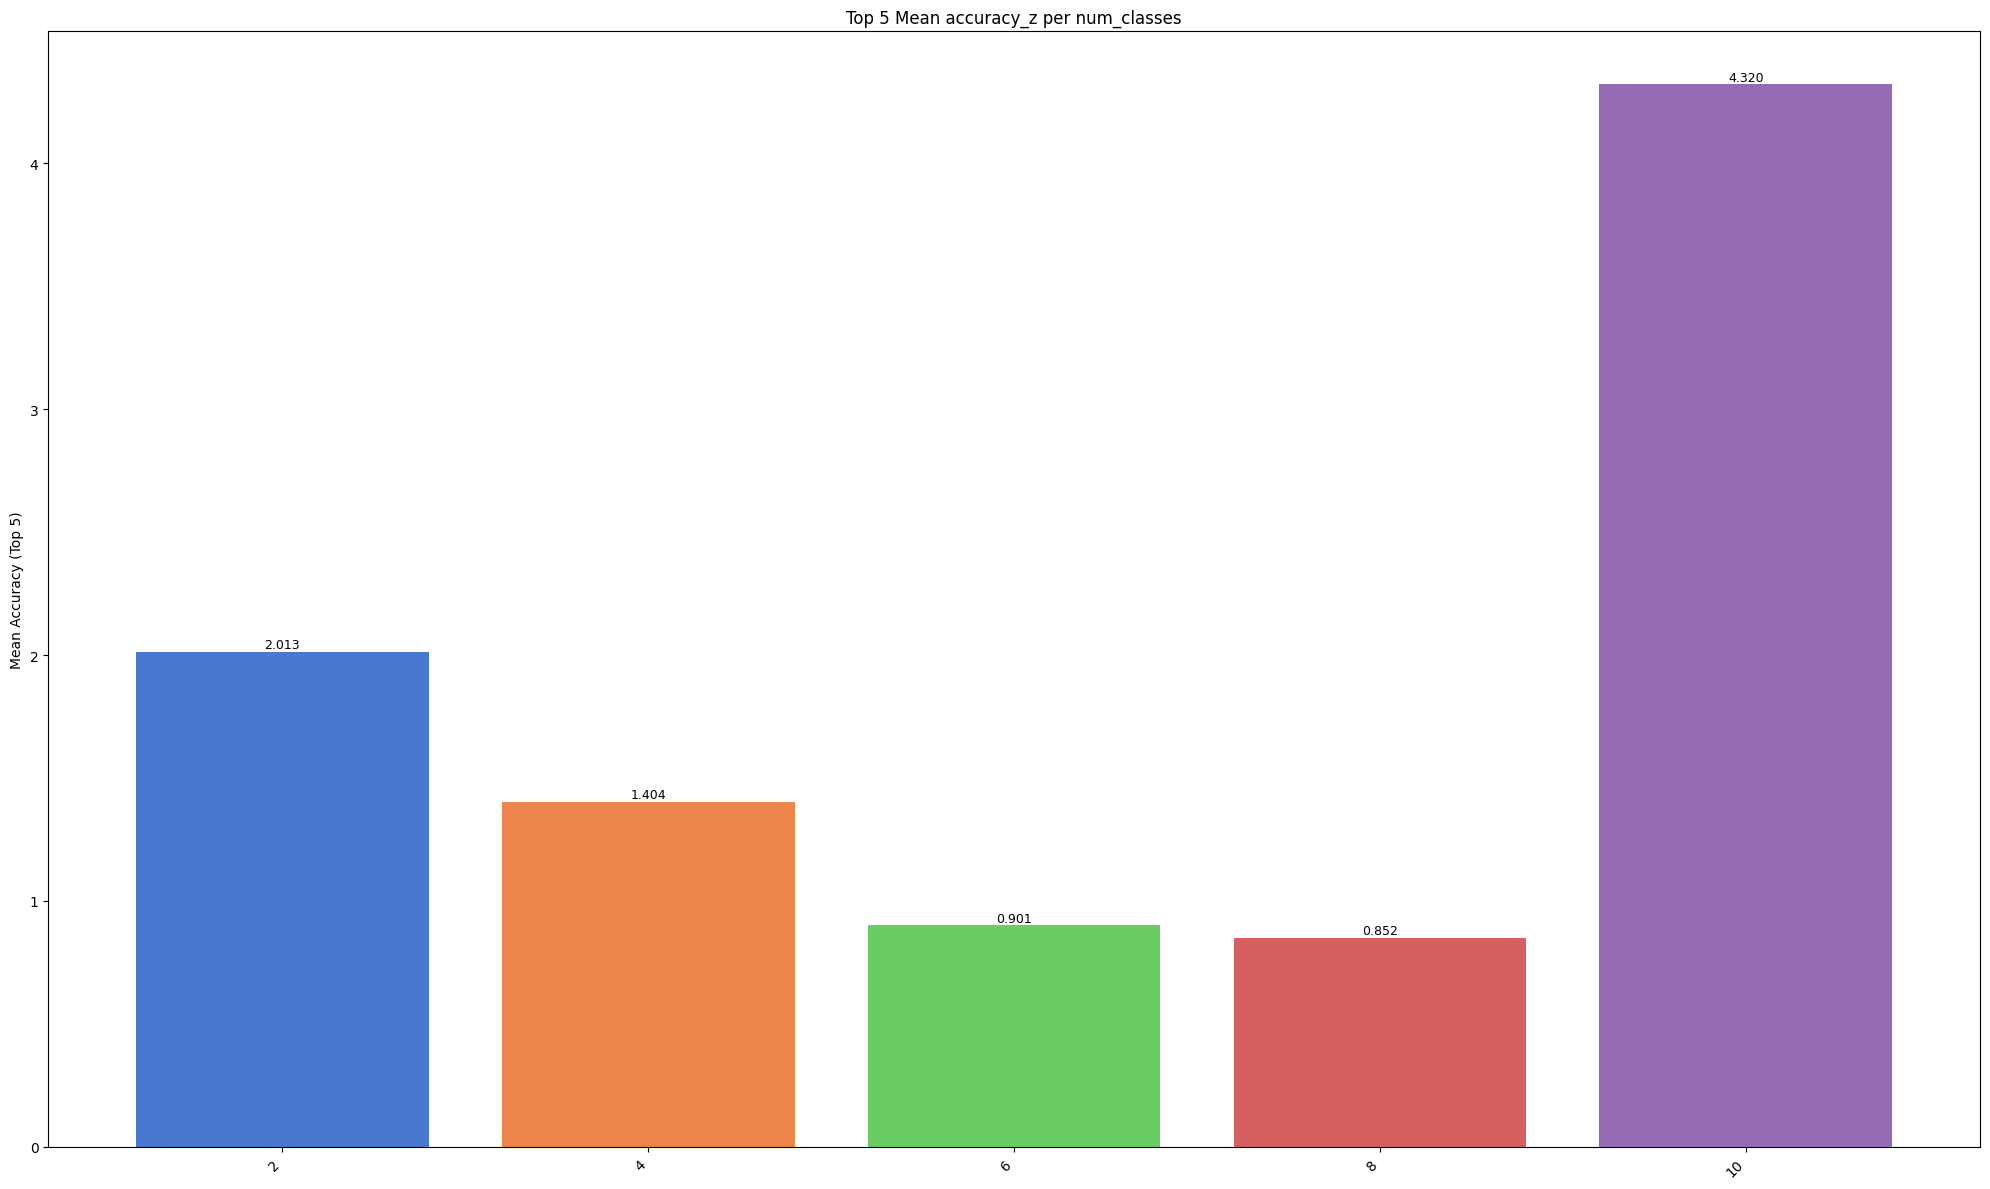

In [406]:
visualize(scores_df, group_cols=['num_classes'], top=top_barrier)

### Inital number-of-classes-agnostic analysis

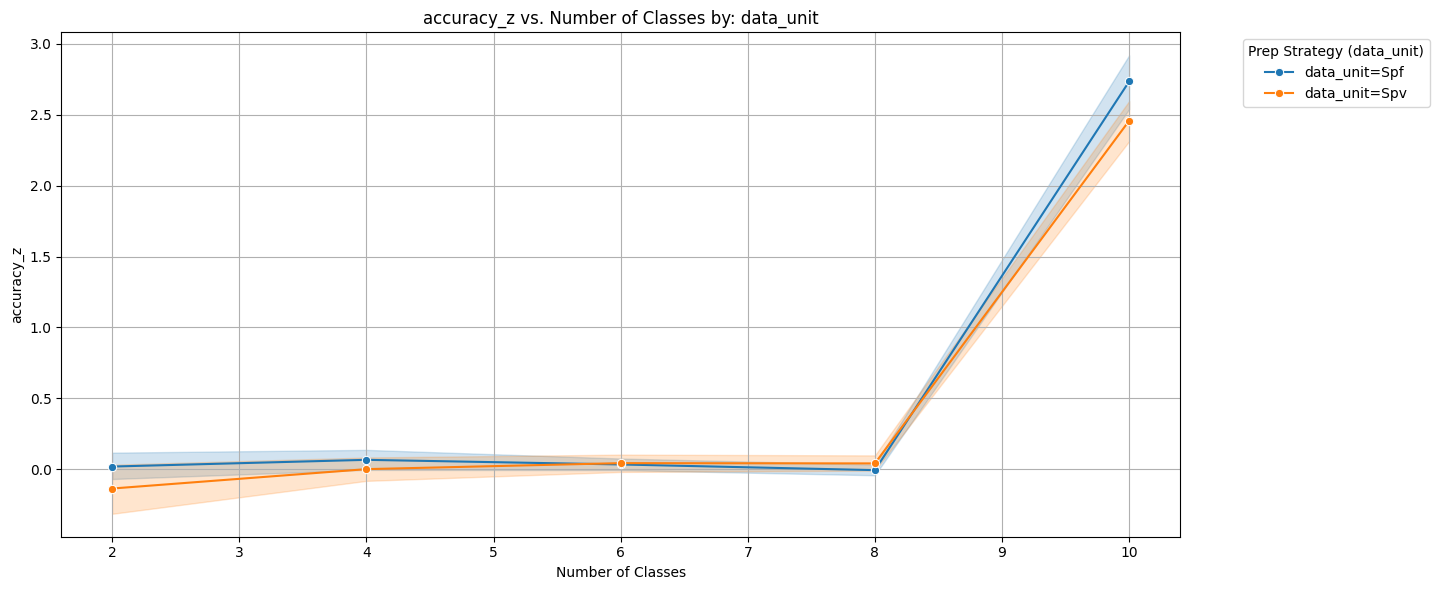

In [407]:
evolution(scores_df, prep_cols=['data_unit'])

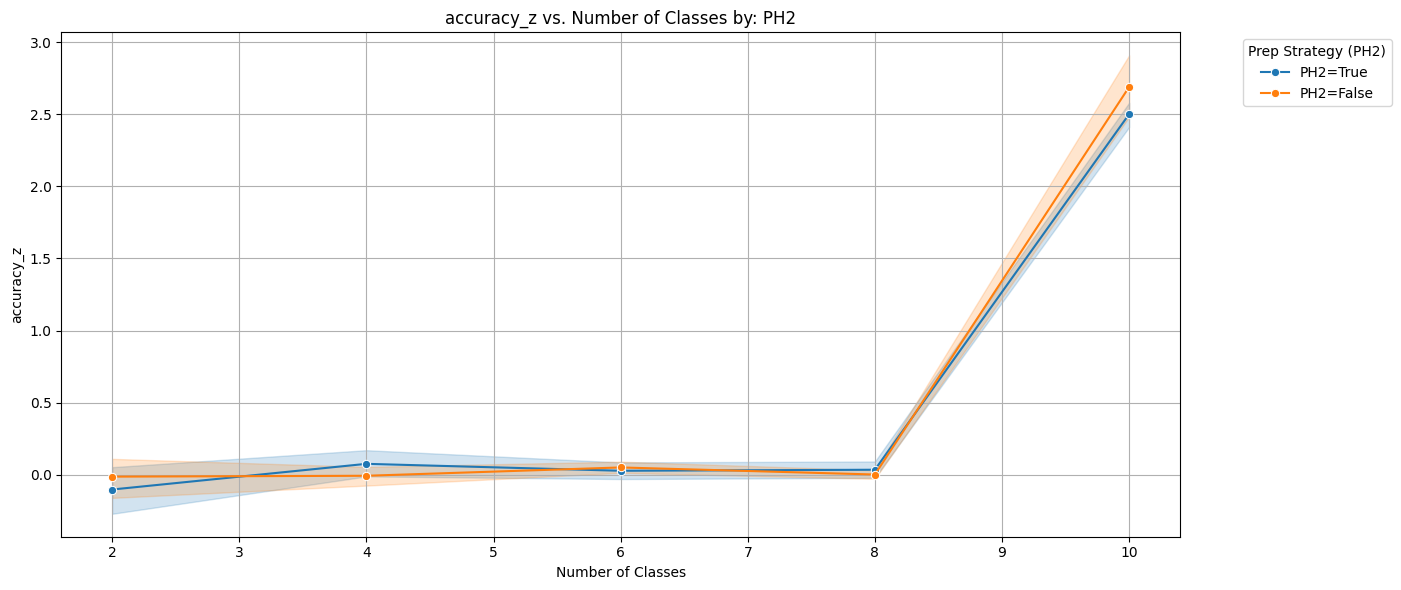

In [408]:
evolution(scores_df, prep_cols=['PH2'])

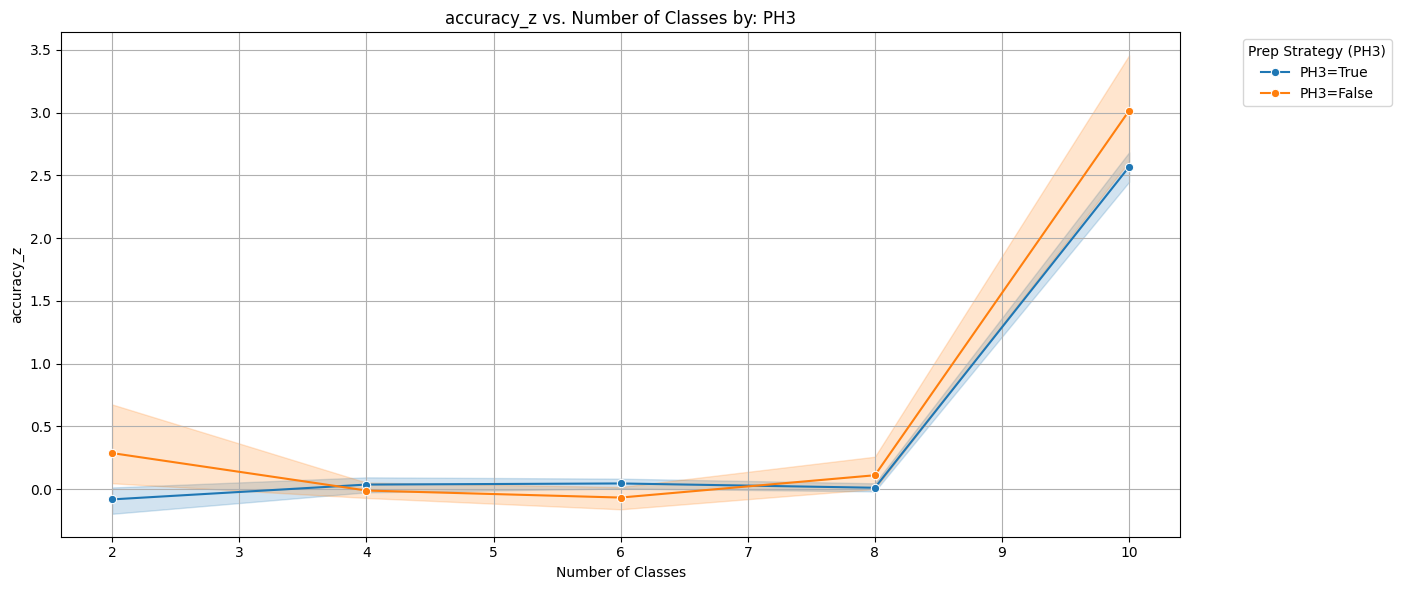

In [409]:
evolution(scores_df, prep_cols=['PH3'])

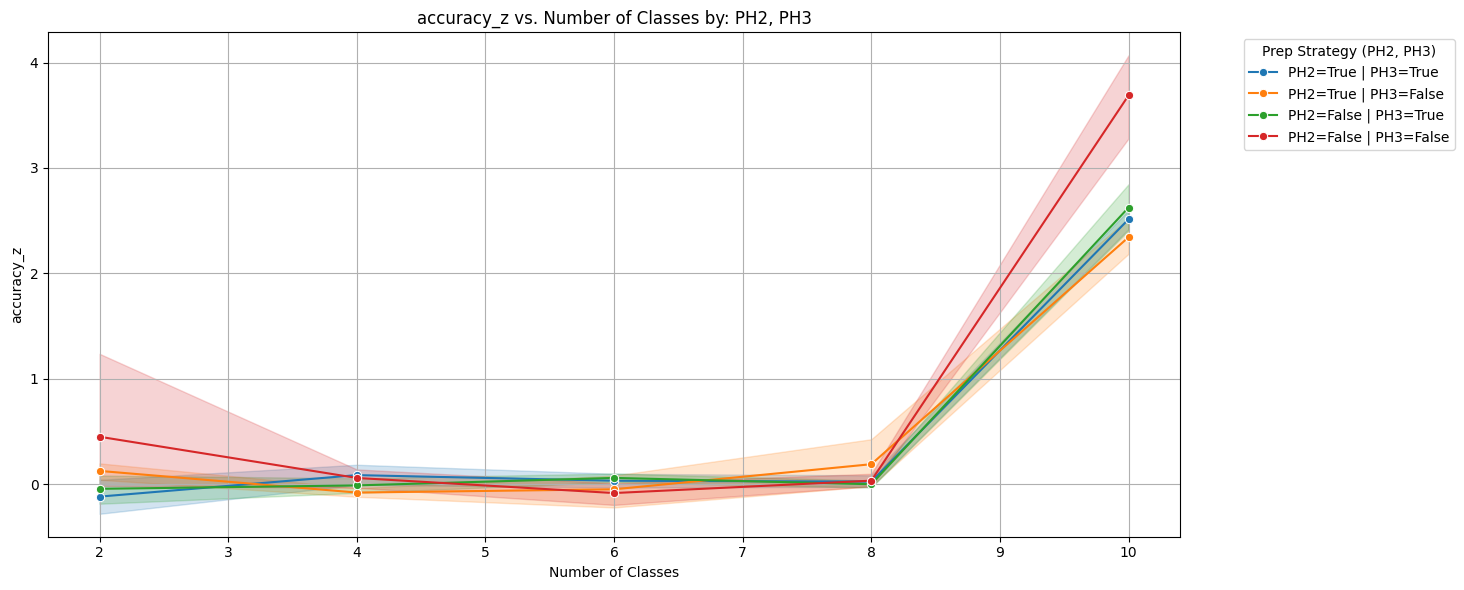

In [410]:
evolution(scores_df, prep_cols=['PH2','PH3'])

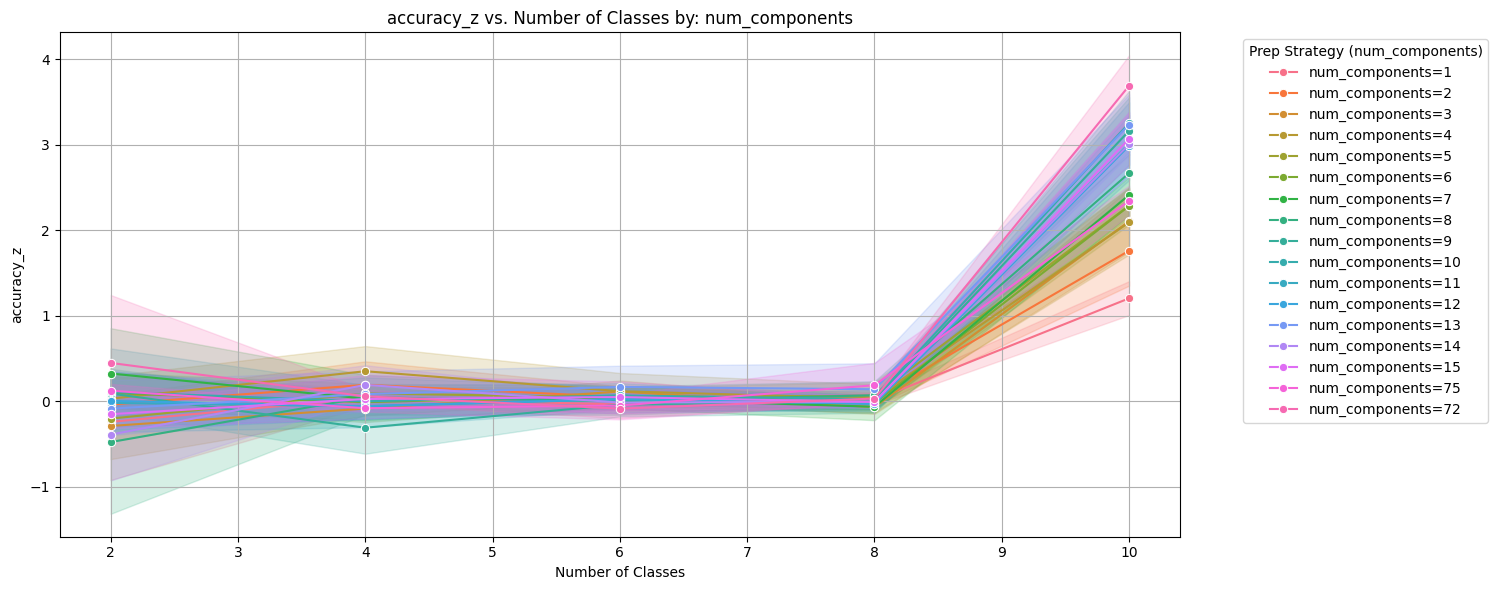

In [411]:
evolution(scores_df, prep_cols=['num_components'])

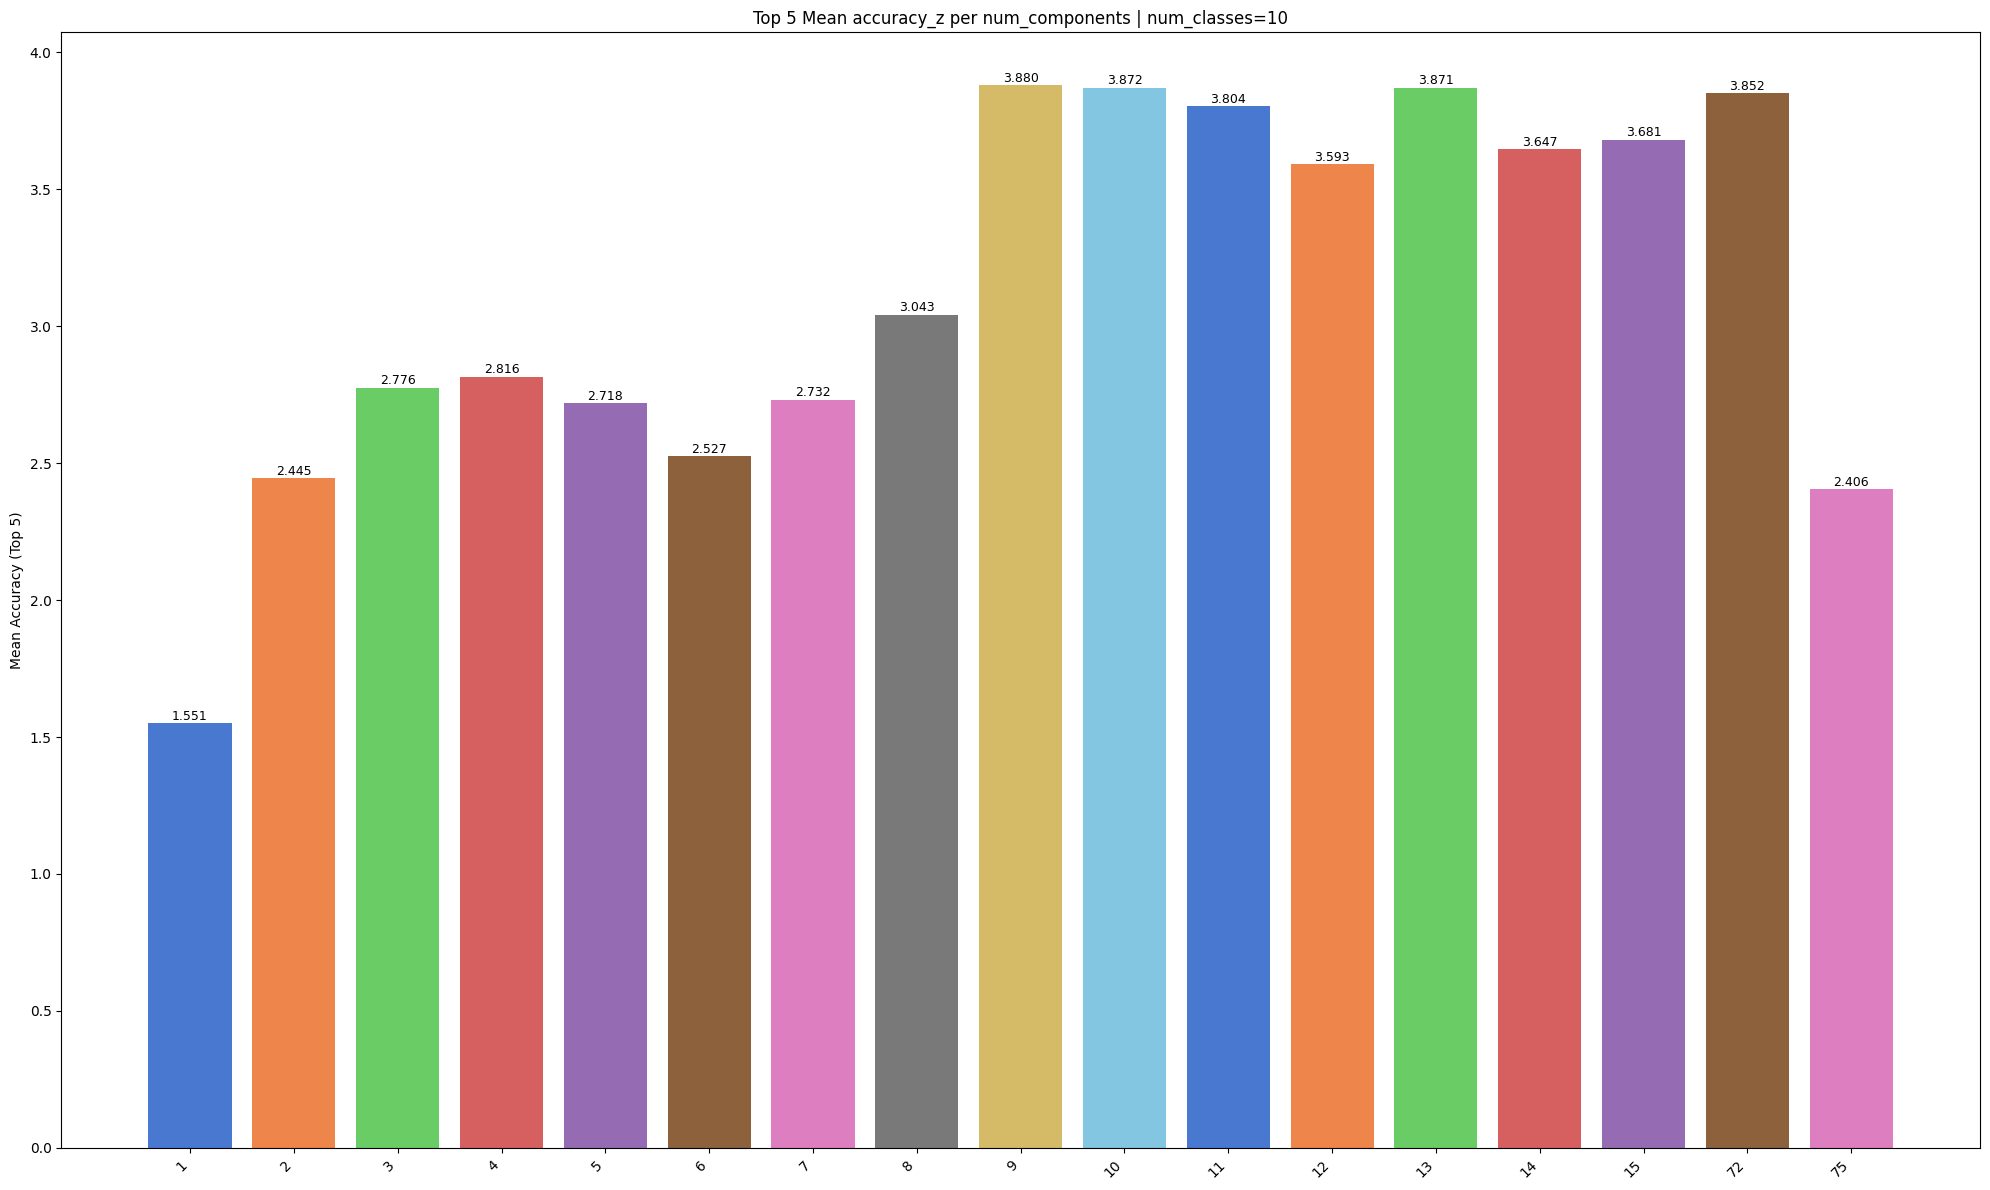

In [412]:
visualize(scores_df, group_cols=['num_components'], filter_cols=['num_classes'], filter_values=[num_classes], top=top_barrier)

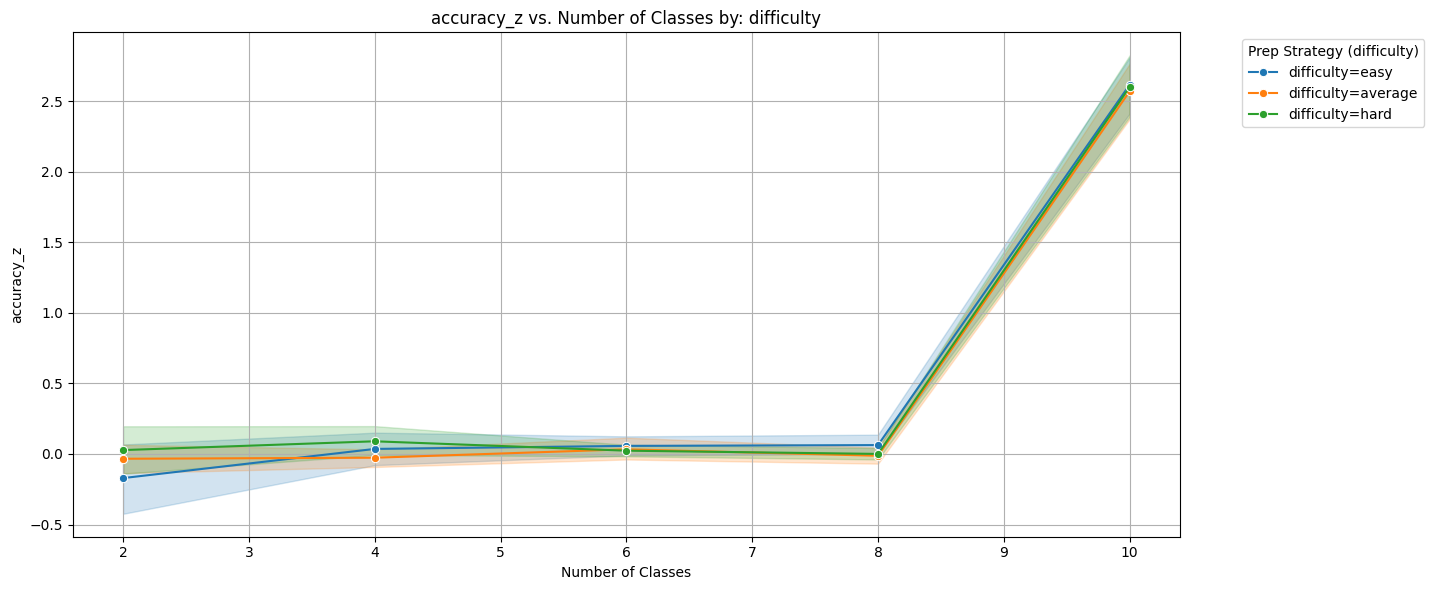

In [413]:
evolution(scores_df, prep_cols=['difficulty'])